<a href="https://colab.research.google.com/github/Siralde/PlantVillageHomeWork/blob/main/PlantVillage_Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

/Users/aldemarogonzalez/anaconda3/envs/master/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preparation

In [13]:
(train_data, test_data), dataset_info = tfds.load(
    'plant_village',
    split=['train[:60%]', 'train[60%:]'],
    with_info=True,
    as_supervised=True
)

In [14]:
def preprocess(image, label):
    image = tf.image.resize(image, (150, 150))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

train_batches = train_data.shuffle(10000).batch(batch_size).map(preprocess).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_data.batch(batch_size).map(preprocess)

In [15]:
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    return image, label

augmented_train_batches = train_batches.map(data_augmentation)

In [16]:
# Suponiendo que train_data es tu conjunto de datos cargado:

# Determinar el tamaño del dataset
DATASET_SIZE = len(train_data)

# Establecer un tamaño para la validación, por ejemplo, el 20%
val_size = int(0.2 * DATASET_SIZE)
train_size = DATASET_SIZE - val_size

# Aleatorizar y dividir en entrenamiento y validación
full_dataset = train_data.shuffle(buffer_size=DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

# Crear batches y aplicar preprocesamiento
batch_size = 32
train_batches = train_dataset.shuffle(buffer_size=train_size).batch(batch_size).map(data_augmentation).prefetch(tf.data.experimental.AUTOTUNE)
val_batches = val_dataset.batch(batch_size).map(preprocess)

In [17]:
num_classes = dataset_info.features['label'].num_classes

# Modelos Creados

## Secuencial

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

model = tf.keras.models.Sequential([
    # Primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Segunda capa convolucional
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Tercera capa convolucional
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Aplanamiento
    tf.keras.layers.Flatten(),
    # Capa densa
    tf.keras.layers.Dense(512, activation='relu'),
    # Capa de salida
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(augmented_train_batches, validation_data=test_batches, epochs=10)

Epoch 1/10
1019/1019 [==============================] - 717s 700ms/step - loss: 1.4813 - accuracy: 0.5827 - val_loss: 0.7220 - val_accuracy: 0.7704
Epoch 2/10
1019/1019 [==============================] - 854s 835ms/step - loss: 0.5931 - accuracy: 0.8153 - val_loss: 0.4604 - val_accuracy: 0.8524
Epoch 3/10
1019/1019 [==============================] - 677s 661ms/step - loss: 0.3875 - accuracy: 0.8765 - val_loss: 0.4322 - val_accuracy: 0.8601
Epoch 4/10
1019/1019 [==============================] - 674s 659ms/step - loss: 0.2891 - accuracy: 0.9050 - val_loss: 0.2704 - val_accuracy: 0.9123
Epoch 5/10
1019/1019 [==============================] - 685s 671ms/step - loss: 0.2385 - accuracy: 0.9210 - val_loss: 0.3270 - val_accuracy: 0.8937
Epoch 6/10
1019/1019 [==============================] - 693s 678ms/step - loss: 0.2052 - accuracy: 0.9344 - val_loss: 0.2524 - val_accuracy: 0.9196
Epoch 7/10
1019/1019 [==============================] - 690s 675ms/step - loss: 0.1848 - accuracy: 0.9381 - val_

## Autoencoders

In [ ]:
input_img = Input(shape=(150, 150, 3))  # Forma de las imágenes del dataset PlantVillage

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


#train_batches_autoencoders = train_batches.map(lambda x: (x, x))


# Suponiendo que 'train_batches' y 'val_batches' ya están definidos como antes.
history_autoencoder = autoencoder.fit(train_batches,
                                      epochs=10,
                                      validation_data=(val_batches, val_batches))


# Modelos Preentrenados

## VGG16

In [12]:
from tensorflow.keras.applications import VGG16

vgg16_model = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
for layer in vgg16_model.layers:
    layer.trainable = False  # Congelamos las capas para conservar las características aprendidas previamente

vgg16_model_personalizado = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

vgg16_model_personalizado.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_vgg16 = vgg16_model_personalizado.fit(train_batches,
                                epochs=10,
                                validation_data=val_batches)



Epoch 1/10
1019/1019 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.7076

2023-09-07 10:02:43.087807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 23110 of 32582
2023-09-07 10:02:47.077352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7998s 8s/step - loss: 0.9701 - accuracy: 0.7076 - val_loss: 0.3520 - val_accuracy: 0.8967
Epoch 2/10
1019/1019 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8226

2023-09-07 12:14:54.582069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 20031 of 32582
2023-09-07 12:15:01.330743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7908s 8s/step - loss: 0.5421 - accuracy: 0.8226 - val_loss: 0.2339 - val_accuracy: 0.9262
Epoch 3/10
1019/1019 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.8485

2023-09-07 14:25:03.688450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 24218 of 32582
2023-09-07 14:25:07.574573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7788s 8s/step - loss: 0.4574 - accuracy: 0.8485 - val_loss: 0.2123 - val_accuracy: 0.9328
Epoch 4/10
1019/1019 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8631

2023-09-07 16:33:23.772018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 24018 of 32582
2023-09-07 16:33:27.641547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7706s 8s/step - loss: 0.4061 - accuracy: 0.8631 - val_loss: 0.1667 - val_accuracy: 0.9471
Epoch 5/10
1019/1019 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8746

2023-09-07 18:42:51.495133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 25493 of 32582
2023-09-07 18:42:54.962453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7746s 8s/step - loss: 0.3684 - accuracy: 0.8746 - val_loss: 0.1566 - val_accuracy: 0.9503
Epoch 6/10
1019/1019 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.8838

2023-09-07 20:53:08.928599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 22565 of 32582
2023-09-07 20:53:13.457681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7897s 8s/step - loss: 0.3405 - accuracy: 0.8838 - val_loss: 0.1250 - val_accuracy: 0.9596
Epoch 7/10
1019/1019 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8917

2023-09-07 23:09:04.027926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 22187 of 32582
2023-09-07 23:09:08.939744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 8153s 8s/step - loss: 0.3161 - accuracy: 0.8917 - val_loss: 0.1168 - val_accuracy: 0.9569
Epoch 8/10
1019/1019 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8974

2023-09-08 01:22:41.742352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 22749 of 32582
2023-09-08 01:22:46.320888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7997s 8s/step - loss: 0.2950 - accuracy: 0.8974 - val_loss: 0.1042 - val_accuracy: 0.9655
Epoch 9/10
1019/1019 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.9039

2023-09-08 03:34:59.131581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 23962 of 32582
2023-09-08 03:35:02.868623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1019/1019 [==============================] - 7733s 8s/step - loss: 0.2813 - accuracy: 0.9039 - val_loss: 0.0857 - val_accuracy: 0.9696
Epoch 10/10
1019/1019 [==============================] - 3966s 4s/step - loss: 0.2648 - accuracy: 0.9082 - val_loss: 0.0918 - val_accuracy: 0.9676


In [33]:
print(history['epoch'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Rest Net

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

for layer in resnet50.layers:
    layer.trainable = False

resnet_model = Sequential([
    resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_resnet = resnet_model.fit(train_batches,
                                  epochs=10,
                                  validation_data=val_batches)

# Conclusiones
## Graficas Comparativas

In [38]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

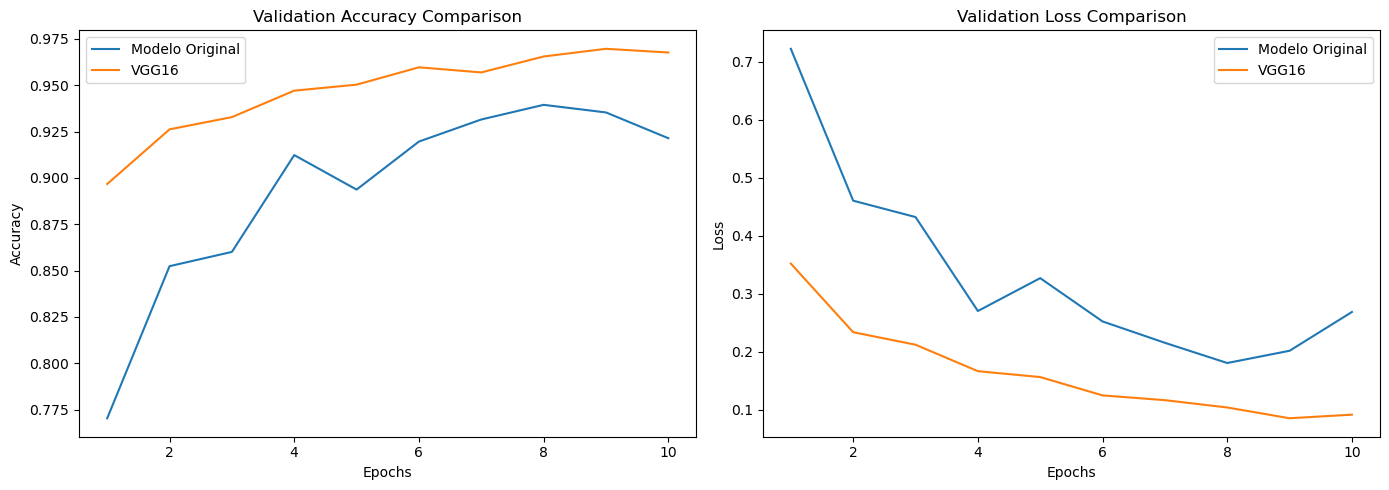

In [40]:
plt.figure(figsize=(14, 5))

# Comparación de Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs, history['val_accuracy'], label='Modelo Original')
#plt.plot(epochs, history_autoencoder['val_accuracy'], label='Autoencoders')
plt.plot(epochs, history_vgg16.history['val_accuracy'], label='VGG16')
#plt.plot(epochs, history_resnet.history['val_accuracy'], label='ResNet50')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Comparación de Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_loss'], label='Modelo Original')
#plt.plot(epochs, history_autoencoder['val_loss'], label='Autoencoders')
plt.plot(epochs, history_vgg16.history['val_loss'], label='VGG16')
#plt.plot(epochs, history_resnet.history['val_loss'], label='ResNet50')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()